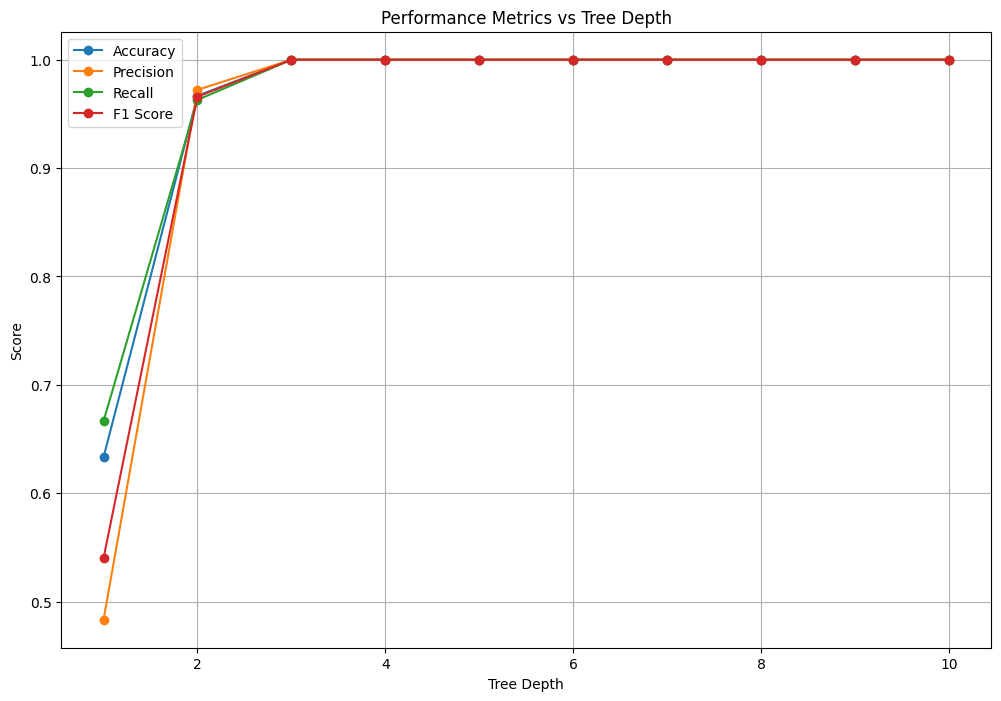

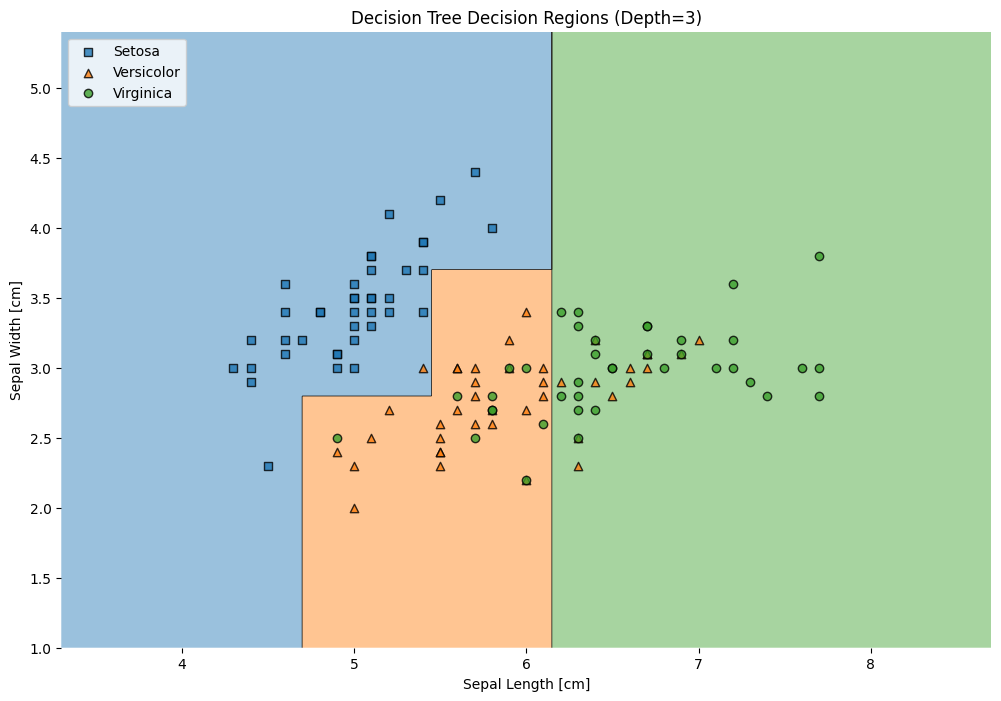

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


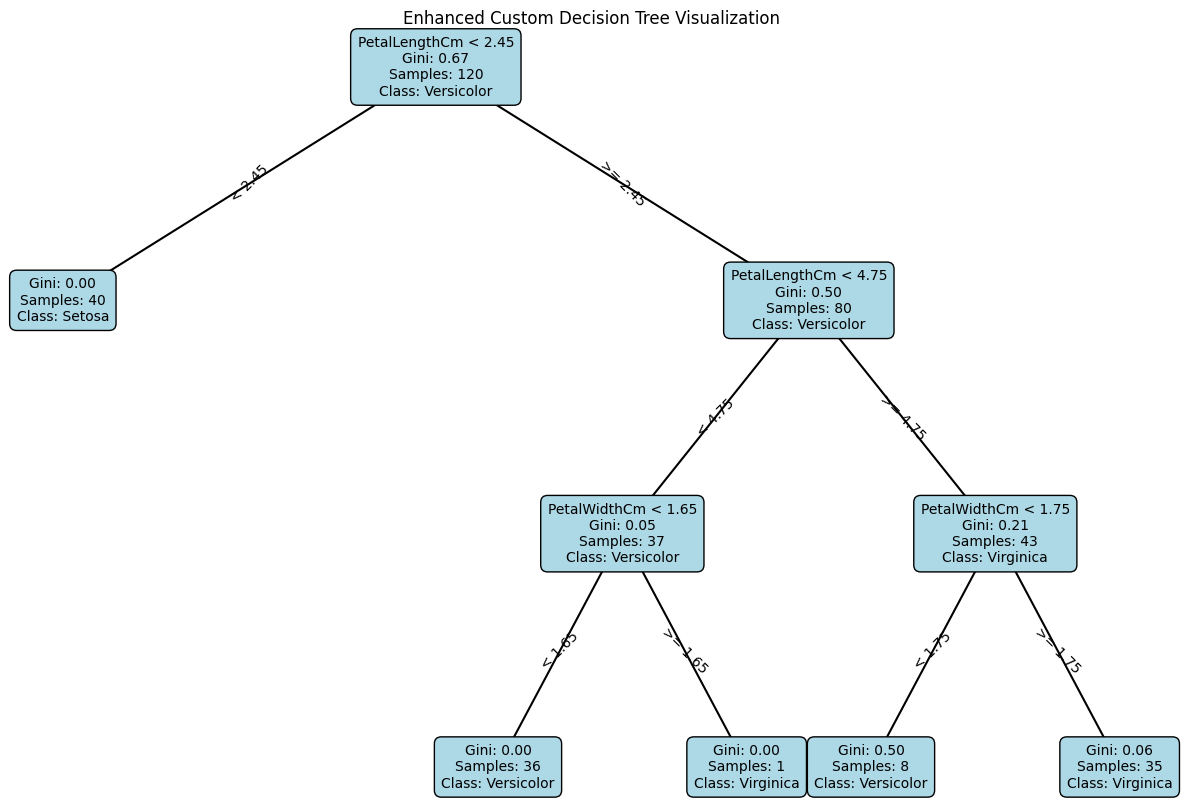

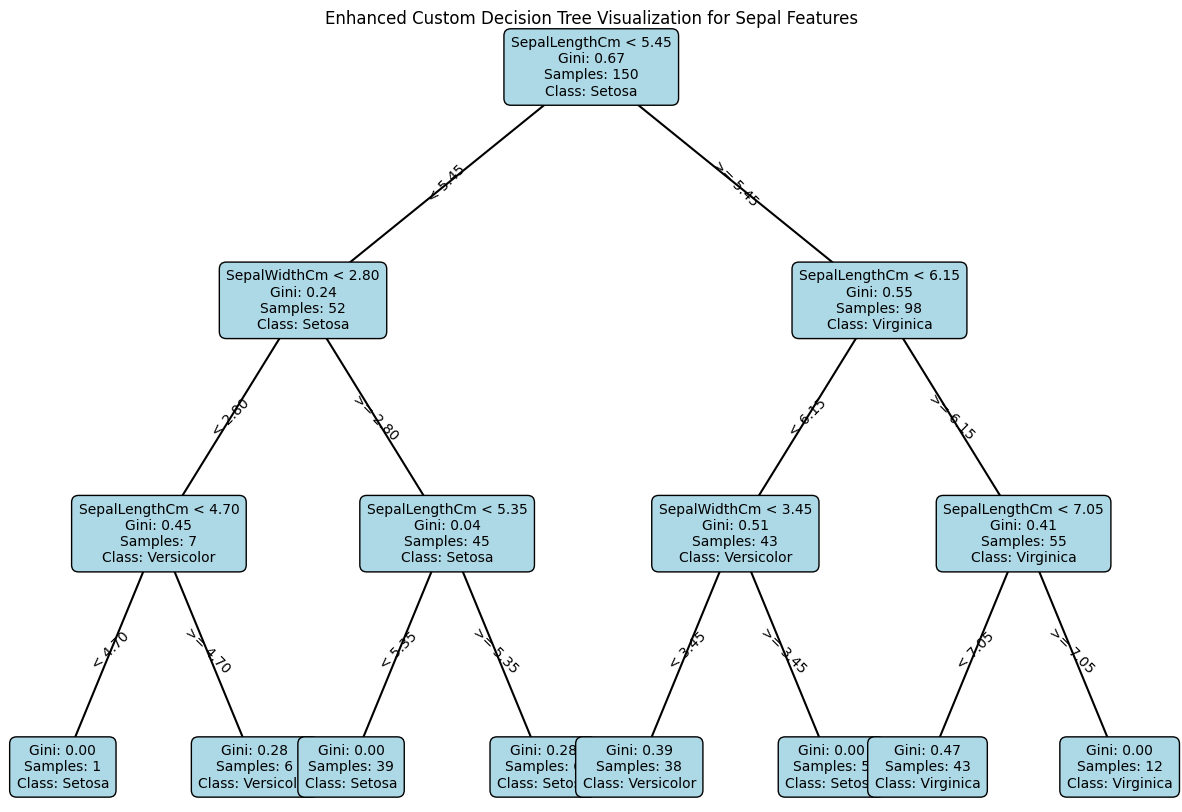

In [7]:
# Problem #1: Decision Tree Depth Optimization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

# Load the Iris dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
column_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
iris_data = pd.read_csv(url, header=None, names=column_names)

# Convert species names to numerical labels
iris_data['Species'] = iris_data['Species'].astype('category').cat.codes

# Split the dataset into features and target variable
X = iris_data.drop('Species', axis=1)
y = iris_data['Species']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Implementation
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((num / m) ** 2 for num in num_parent)
        best_idx, best_thr = None, None

        for idx in range(n):
            valid_indices = ~np.isnan(X[:, idx])
            X_valid = X[valid_indices, idx]
            y_valid = y[valid_indices]

            if len(X_valid) <= 1:
                continue

            thresholds, classes = zip(*sorted(zip(X_valid, y_valid)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, len(X_valid)):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes_))
                gini_right = 1.0 - sum((num_right[x] / (len(X_valid) - i)) ** 2 for x in range(self.n_classes_))
                gini = (i * gini_left + (len(X_valid) - i) * gini_right) / len(X_valid)
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

# Initialize lists to store performance metrics
depths = list(range(1, 11))
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Train a decision tree with various maximum depths and evaluate performance
for depth in depths:
    model = DecisionTree(max_depth=depth)
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))

# Plot the performance metrics against the tree depth
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies, label='Accuracy', marker='o')
plt.plot(depths, precisions, label='Precision', marker='o')
plt.plot(depths, recalls, label='Recall', marker='o')
plt.plot(depths, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Performance Metrics vs Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

# Map numerical labels back to species names
label_dict = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

# Convert y_train and y_test to species names
y_train_labels = np.array([label_dict[label] for label in y_train])
y_test_labels = np.array([label_dict[label] for label in y_test])

# Visualize the decision boundaries of the best-performing model
best_depth = depths[np.argmax(f1_scores)]
best_model = DecisionTree(max_depth=best_depth)
best_model.fit(X_train.values, y_train.values)

# Select only two features for visualization
X_vis = X[['SepalLengthCm', 'SepalWidthCm']].values
y_vis = y.values

# Split the dataset into training and testing sets again with only two features
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y_vis, test_size=0.2, random_state=42)

# Convert y_train_vis and y_test_vis to species names for visualization
y_train_vis_labels = np.array([label_dict[label] for label in y_train_vis])
y_test_vis_labels = np.array([label_dict[label] for label in y_test_vis])

# Train the decision tree with the best-performing depth on the visualization data
best_model_vis = DecisionTree(max_depth=best_depth)
best_model_vis.fit(X_train_vis, y_train_vis)

# Plot decision regions with a labeled legend
plt.figure(figsize=(12, 8))
plot_decision_regions(X_train_vis, y_train_vis, clf=best_model_vis, legend=2)

# Label the legend with class names
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [label_dict[int(label)] for label in labels], loc='upper left')

plt.xlabel('Sepal Length [cm]')
plt.ylabel('Sepal Width [cm]')
plt.title(f'Decision Tree Decision Regions (Depth={best_depth})')
plt.show()

# Evaluate the model using class labels
y_pred = best_model.predict(X_test.values)
y_pred_labels = np.array([label_dict[label] for label in y_pred])

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='macro', zero_division=0)
recall = recall_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Enhanced custom decision tree plot
def plot_custom_tree_with_labeled_rules(node, depth=0, x=0, y=0, spacing=1.0, parent=None, branch_label=None):
    if node is not None:
        # Add decision rule and labels based on feature names
        if node.left or node.right:
            feature_name = column_names[node.feature_index]
            decision_rule = f"{feature_name} < {node.threshold:.2f}"
            label = f"{decision_rule}\nGini: {node.gini:.2f}\nSamples: {node.num_samples}\nClass: {label_dict[node.predicted_class]}"
        else:
            label = f"Gini: {node.gini:.2f}\nSamples: {node.num_samples}\nClass: {label_dict[node.predicted_class]}"
        
        # Display the node
        plt.text(x, y, label, ha='center', va='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))
        
        # Draw branches and labels on them
        if node.left is not None:
            x_left = x - spacing / (depth + 1)
            y_left = y - 1
            plt.plot([x, x_left], [y, y_left], 'k-')
            # Add branch label for the decision condition
            plt.text((x + x_left) / 2, (y + y_left) / 2, f"< {node.threshold:.2f}", ha='center', va='center', rotation=45)
            plot_custom_tree_with_labeled_rules(node.left, depth + 1, x_left, y_left, spacing, node, f"< {node.threshold:.2f}")
        
        if node.right is not None:
            x_right = x + spacing / (depth + 1)
            y_right = y - 1
            plt.plot([x, x_right], [y, y_right], 'k-')
            # Add branch label for the decision condition
            plt.text((x + x_right) / 2, (y + y_right) / 2, f">= {node.threshold:.2f}", ha='center', va='center', rotation=-45)
            plot_custom_tree_with_labeled_rules(node.right, depth + 1, x_right, y_right, spacing, node, f">= {node.threshold:.2f}")

# Plotting the enhanced custom decision tree with labeled decision rules on branches
plt.figure(figsize=(15, 10))
plot_custom_tree_with_labeled_rules(best_model.tree)
plt.axis('off')
plt.title('Enhanced Custom Decision Tree Visualization')
plt.show()

# Enhanced custom decision tree plot specifically for Sepal features
def plot_custom_tree_with_labeled_rules_sepal(node, depth=0, x=0, y=0, spacing=1.0, parent=None, branch_label=None):
    if node is not None:
        # Add decision rule and labels based on Sepal feature names
        sepal_column_names = ['SepalLengthCm', 'SepalWidthCm']
        
        if node.left or node.right:
            feature_name = sepal_column_names[node.feature_index]
            decision_rule = f"{feature_name} < {node.threshold:.2f}"
            label = f"{decision_rule}\nGini: {node.gini:.2f}\nSamples: {node.num_samples}\nClass: {label_dict[node.predicted_class]}"
        else:
            label = f"Gini: {node.gini:.2f}\nSamples: {node.num_samples}\nClass: {label_dict[node.predicted_class]}"
        
        # Display the node
        plt.text(x, y, label, ha='center', va='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))
        
        # Draw branches and labels on them
        if node.left is not None:
            x_left = x - spacing / (depth + 1)
            y_left = y - 1
            plt.plot([x, x_left], [y, y_left], 'k-')
            # Add branch label for the decision condition
            plt.text((x + x_left) / 2, (y + y_left) / 2, f"< {node.threshold:.2f}", ha='center', va='center', rotation=45)
            plot_custom_tree_with_labeled_rules_sepal(node.left, depth + 1, x_left, y_left, spacing, node, f"< {node.threshold:.2f}")
        
        if node.right is not None:
            x_right = x + spacing / (depth + 1)
            y_right = y - 1
            plt.plot([x, x_right], [y, y_right], 'k-')
            # Add branch label for the decision condition
            plt.text((x + x_right) / 2, (y + y_right) / 2, f">= {node.threshold:.2f}", ha='center', va='center', rotation=-45)
            plot_custom_tree_with_labeled_rules_sepal(node.right, depth + 1, x_right, y_right, spacing, node, f">= {node.threshold:.2f}")

# Plotting the enhanced custom decision tree with labeled decision rules on branches for Sepal features
plt.figure(figsize=(15, 10))
plot_custom_tree_with_labeled_rules_sepal(tree_sepal.tree)
plt.axis('off')
plt.title('Enhanced Custom Decision Tree Visualization for Sepal Features')
plt.show()




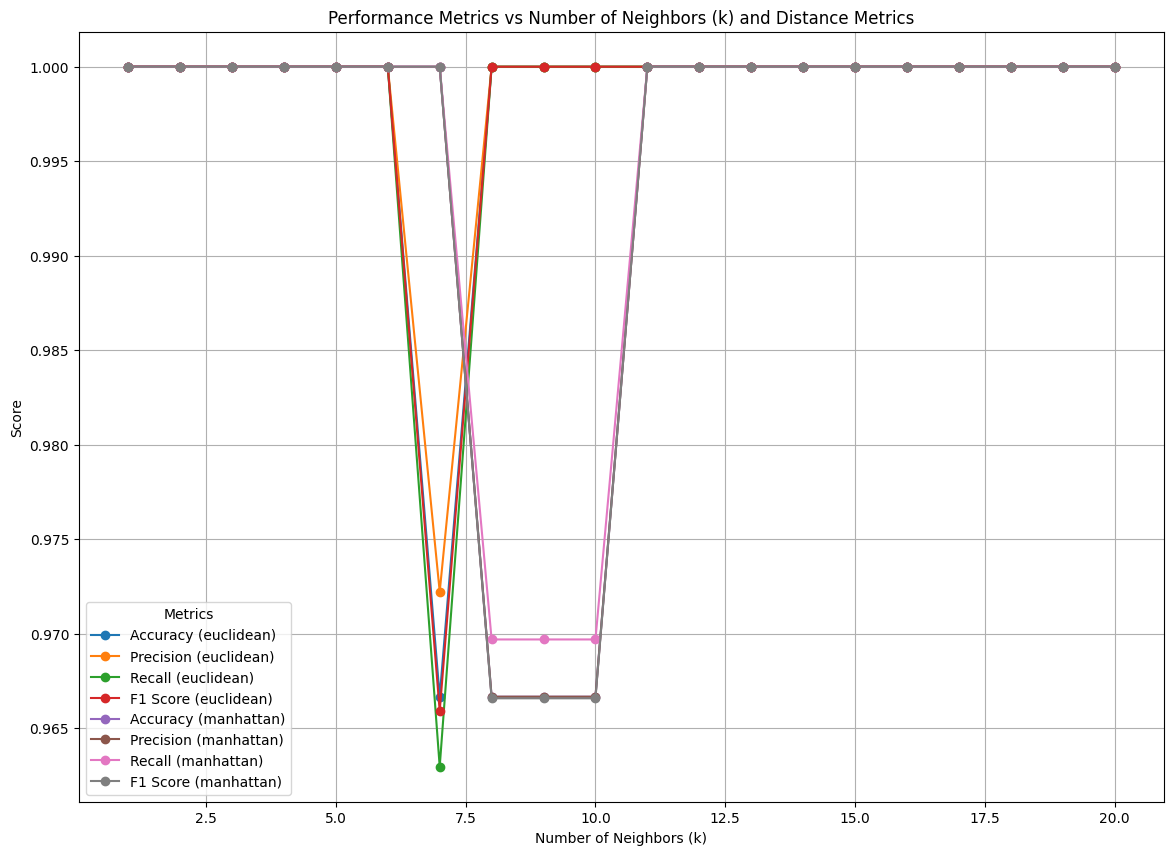

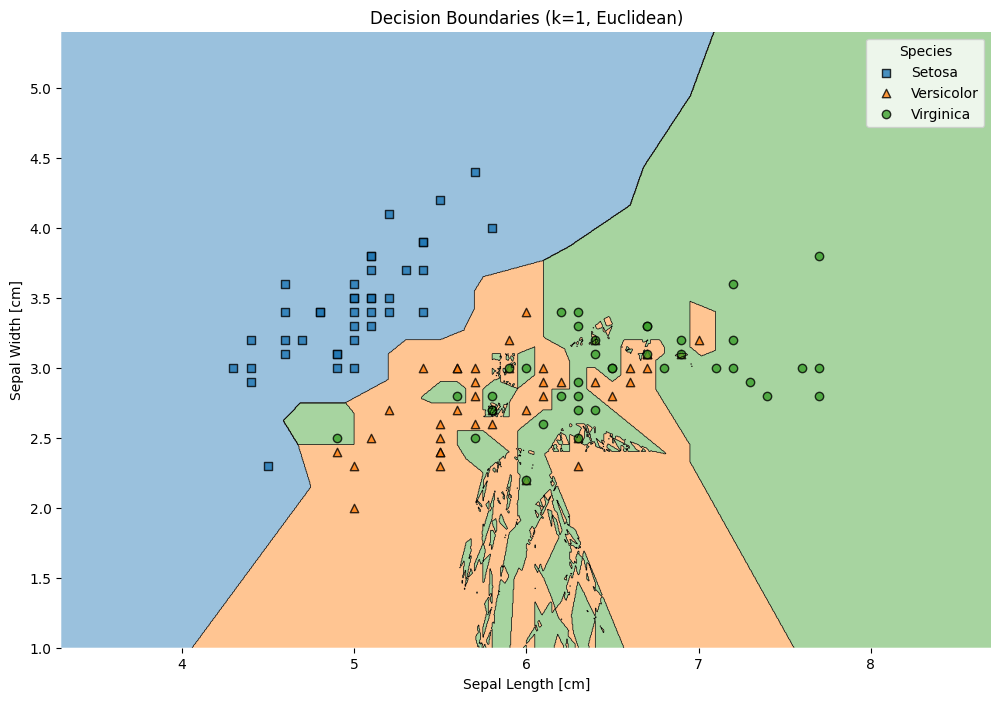

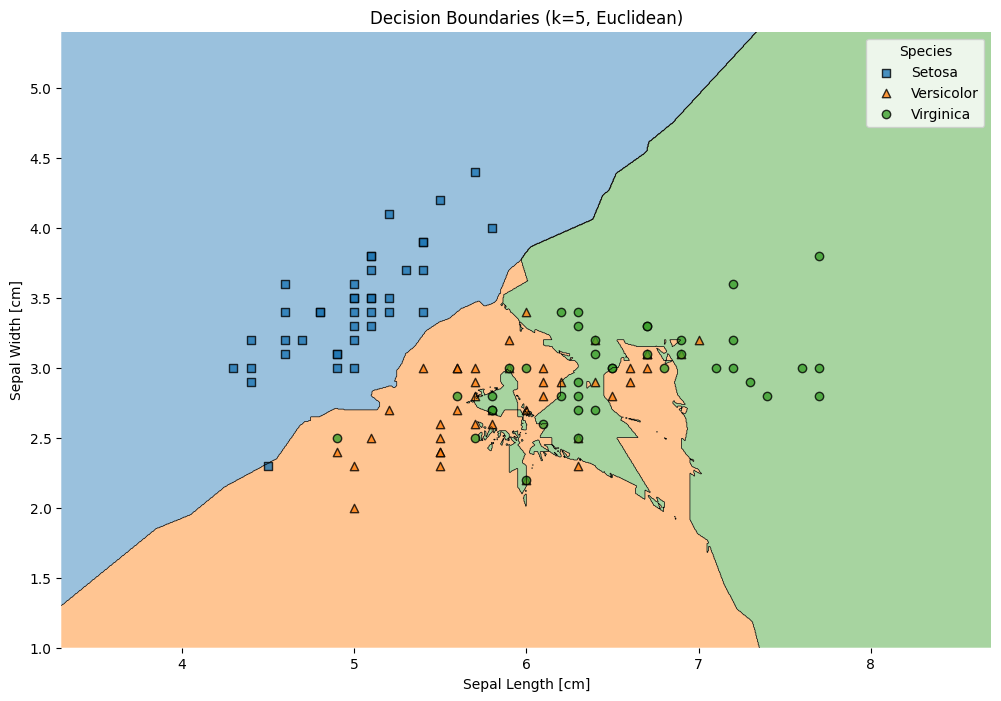

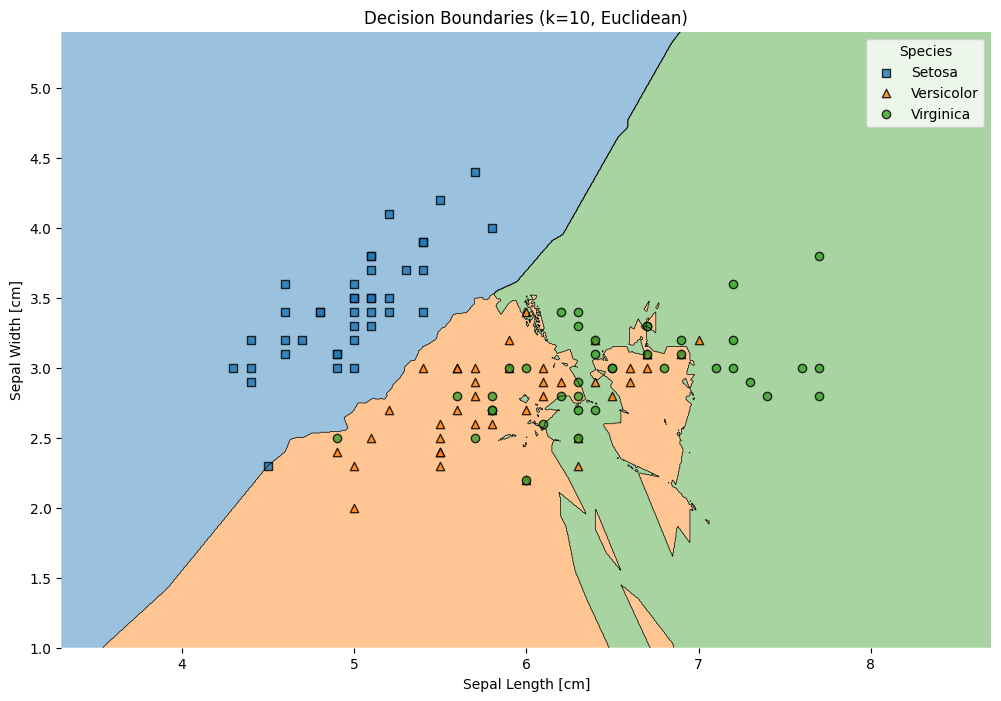

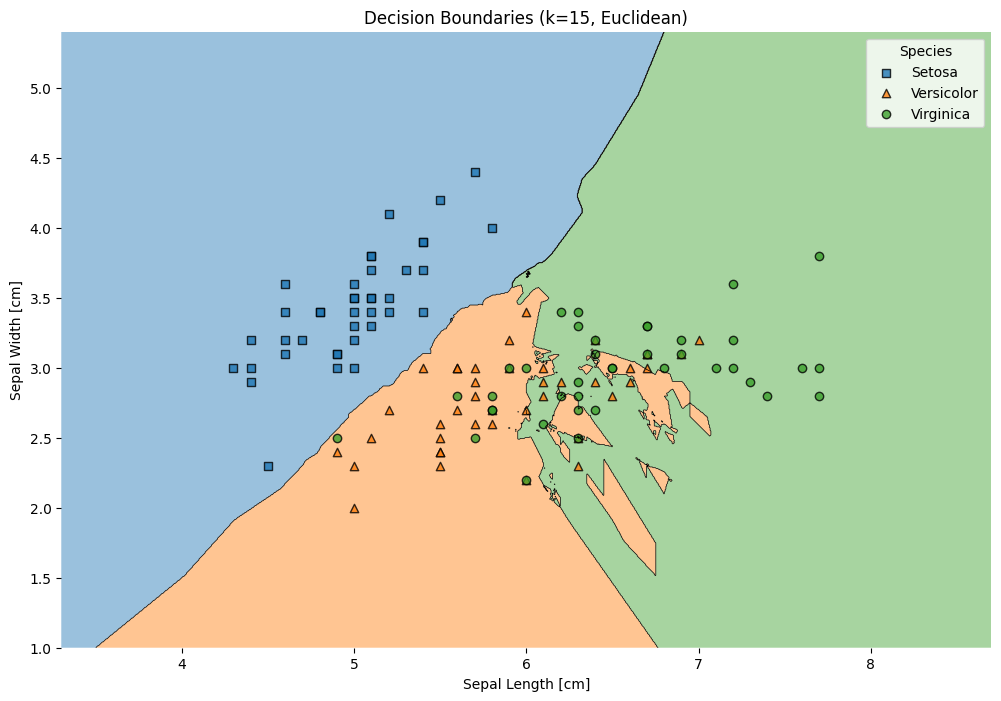

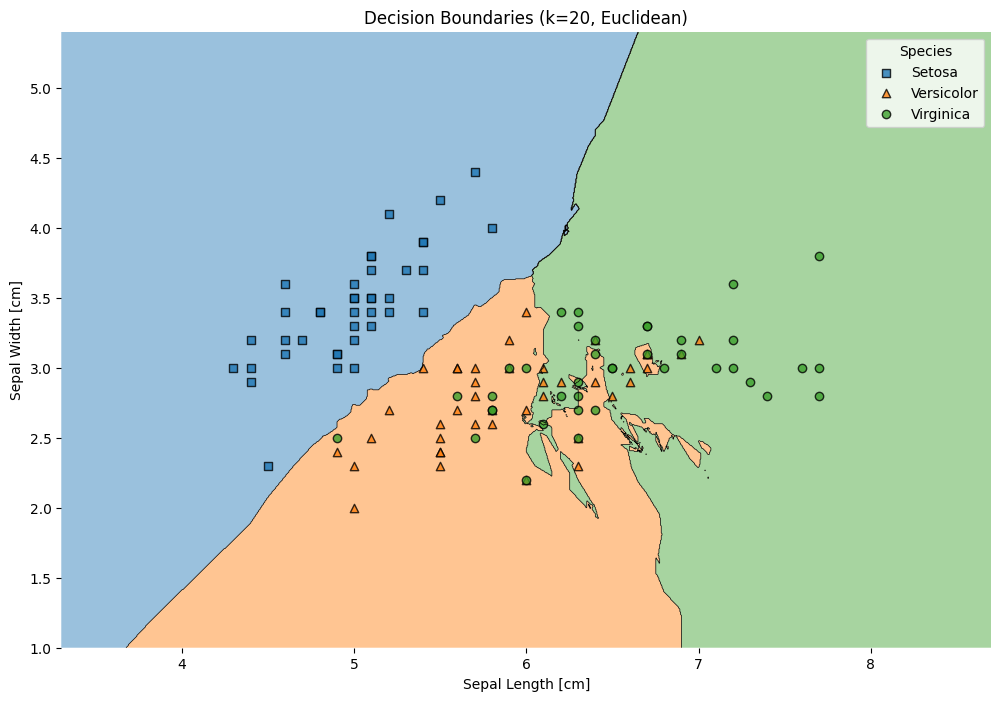

"\nfor k in [1, 5, 10, 15, 20]:\n    knn_vis = KNN(k=k, distance_metric='euclidean')\n    knn_vis.fit(X_train_vis, y_train_vis)\n\n    plt.figure(figsize=(12, 8))\n    plot_decision_regions(X_train_vis, y_train_vis, clf=knn_vis, legend=2)\n    plt.xlabel('Sepal Length [cm]')\n    plt.ylabel('Sepal Width [cm]')\n    plt.title(f'Decision Boundaries (k={k}, Euclidean)')\n    plt.show()\n"

In [24]:
# Problem #2: K-Nearest Neighbors Hyperparameter Tuning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

# Load the Iris dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
column_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
iris_data = pd.read_csv(url, header=None, names=column_names)

# Error handling for missing data
if iris_data.isnull().values.any():
    iris_data = iris_data.dropna()

# Convert species names to numerical labels
iris_data['Species'] = iris_data['Species'].astype('category').cat.codes

# Create a mapping from numerical labels to species names
label_dict = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

# Split the dataset into features and target variable
X = iris_data.drop('Species', axis=1)
y = iris_data['Species']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implementing KNN from scratch
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            predictions[i] = self._predict(x)
        return predictions

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = self._distance(x, self.X_train)

        # Sort by distance and get the k nearest samples
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]

        # Return the most common class label among the k neighbors
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

    def _distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2, axis=1))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2), axis=1)
        else:
            raise ValueError(f"Unknown distance metric: {self.distance_metric}")

# Parameters to tune
k_values = list(range(1, 21))
distance_metrics = ['euclidean', 'manhattan']

# Initialize dictionaries to store performance metrics
results = []

# Train KNN classifiers with different k values and distance metrics
for metric in distance_metrics:
    for k in k_values:
        knn = KNN(k=k, distance_metric=metric)
        knn.fit(X_train.values, y_train.values)
        y_pred = knn.predict(X_test.values)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results.append((k, metric, accuracy, precision, recall, f1))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['k', 'metric', 'accuracy', 'precision', 'recall', 'f1'])

# Plot performance metrics against different k values and distance metrics
plt.figure(figsize=(14, 10))
for metric in distance_metrics:
    subset = results_df[results_df['metric'] == metric]
    plt.plot(subset['k'], subset['accuracy'], label=f'Accuracy ({metric})', marker='o')
    plt.plot(subset['k'], subset['precision'], label=f'Precision ({metric})', marker='o')
    plt.plot(subset['k'], subset['recall'], label=f'Recall ({metric})', marker='o')
    plt.plot(subset['k'], subset['f1'], label=f'F1 Score ({metric})', marker='o')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('Performance Metrics vs Number of Neighbors (k) and Distance Metrics')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

# Visualize the decision boundaries for different k values
# Select only two features for visualization
X_vis = X[['SepalLengthCm', 'SepalWidthCm']].values
y_vis = y.values

# Split the dataset into training and testing sets again with only two features
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y_vis, test_size=0.2, random_state=42)

# Visualize the decision boundaries for different k values using custom KNN class
class KNNVisualizer(KNN):
    def predict(self, X):
        X = np.array(X)
        predictions = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            predictions[i] = self._predict(x)
        return predictions

# Plot decision regions for different k values
for k in [1, 5, 10, 15, 20]:
    knn_vis = KNNVisualizer(k=k, distance_metric='euclidean')
    knn_vis.fit(X_train_vis, y_train_vis)

    plt.figure(figsize=(12, 8))
    plot_decision_regions(X_train_vis, y_train_vis, clf=knn_vis, legend=2)
    plt.xlabel('Sepal Length [cm]')
    plt.ylabel('Sepal Width [cm]')
    plt.title(f'Decision Boundaries (k={k}, Euclidean)')
    # Update legend labels with species names
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [label_dict[int(label)] for label in labels]
    plt.legend(handles, labels, title='Species')
    plt.show()

'''
for k in [1, 5, 10, 15, 20]:
    knn_vis = KNN(k=k, distance_metric='euclidean')
    knn_vis.fit(X_train_vis, y_train_vis)

    plt.figure(figsize=(12, 8))
    plot_decision_regions(X_train_vis, y_train_vis, clf=knn_vis, legend=2)
    plt.xlabel('Sepal Length [cm]')
    plt.ylabel('Sepal Width [cm]')
    plt.title(f'Decision Boundaries (k={k}, Euclidean)')
    plt.show()
'''


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


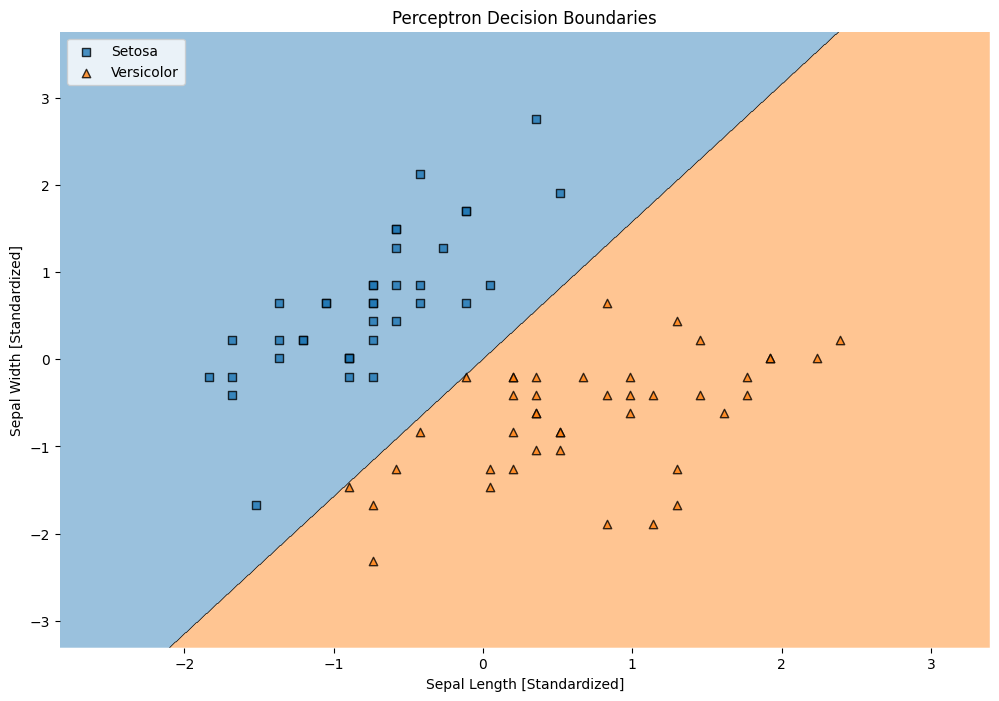

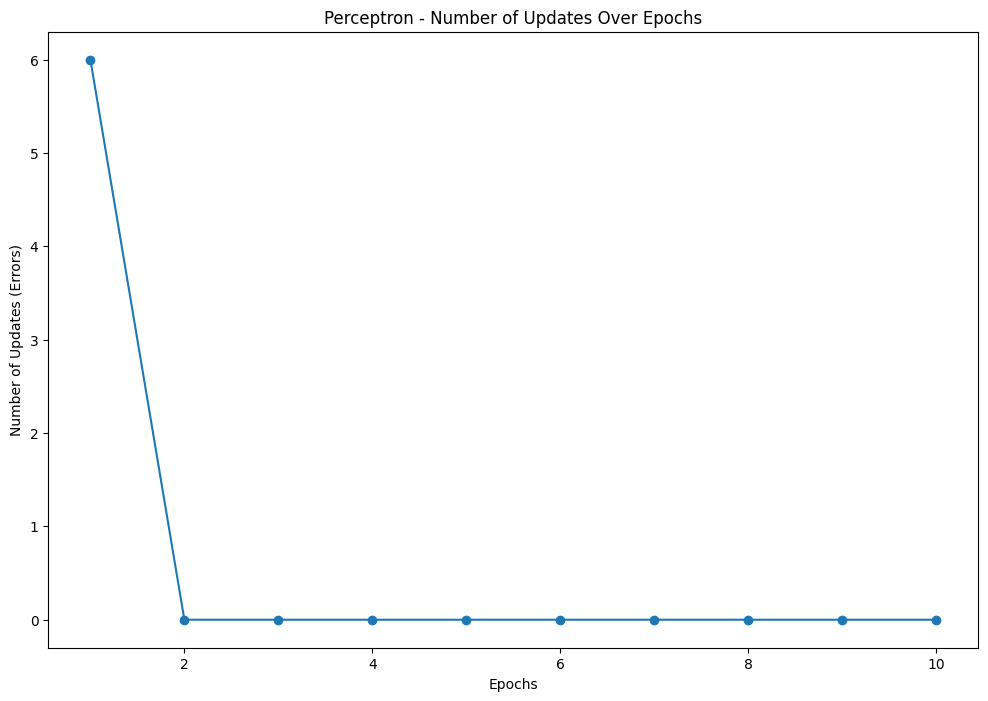

In [1]:
# Problem #3: Perceptron Learning Algorithm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset from a URL and assign column names
# The dataset contains 150 samples from 3 species of iris plants, but we'll use only 2 species for binary classification.
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
column_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
iris_data = pd.read_csv(url, header=None, names=column_names)

# Convert the species names to numerical labels (Setosa = 0, Versicolor = 1, Virginica = 2)
iris_data['Species'] = iris_data['Species'].astype('category').cat.codes

# Use only the first 100 samples for binary classification (Setosa vs Versicolor)
# Setosa is represented by 0, Versicolor by 1
iris_data = iris_data[:100]

# Split the dataset into features (X) and target variable (y)
# We'll use only 'SepalLengthCm' and 'SepalWidthCm' as features for easy 2D visualization
X = iris_data[['SepalLengthCm', 'SepalWidthCm']].values
y = iris_data['Species'].values

# Feature Scaling: Standardize the feature values for better convergence of the Perceptron algorithm
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perceptron implementation from scratch
# The Perceptron is a simple linear classifier that adjusts weights iteratively to classify data
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iter=50):
        """Initialize the Perceptron with a learning rate and number of iterations (epochs)."""
        self.learning_rate = learning_rate  # Step size for weight updates
        self.n_iter = n_iter  # Number of passes over the training data

    def fit(self, X, y):
        """Fit the Perceptron model to the training data."""
        # Initialize weights (w) as a vector of zeros (one more than the number of features for bias)
        self.weights = np.zeros(X.shape[1] + 1)  # +1 for the bias term
        self.errors_ = []  # Track the number of misclassifications (errors) in each epoch
        
        # Iterate through the dataset n_iter times (epochs)
        for _ in range(self.n_iter):
            errors = 0  # Track errors in each epoch
            for xi, target in zip(X, y):
                # Update rule: w = w + learning_rate * (target - predicted) * xi
                # If target and predicted labels don't match, the weights will be updated
                update = self.learning_rate * (target - self.predict(xi))
                self.weights[1:] += update * xi  # Update weights for the features
                self.weights[0] += update  # Update the bias term
                errors += int(update != 0.0)  # Count errors where an update occurs (misclassification)
            self.errors_.append(errors)  # Record the total errors for this epoch
        return self

    def net_input(self, X):
        """Calculate the net input (linear combination of weights and input features)."""
        # Dot product of input features and weights, plus the bias term
        return np.dot(X, self.weights[1:]) + self.weights[0]

    def predict(self, X):
        """Return the class label after applying the unit step function."""
        # If net input >= 0, predict class 1 (Versicolor), else predict class 0 (Setosa)
        return np.where(self.net_input(X) >= 0.0, 1, 0)

# Map numerical labels back to the species names for better readability
label_dict = {0: 'Setosa', 1: 'Versicolor'}

# Train the Perceptron classifier on the training data
# The perceptron adjusts its weights during training using the learning rate and number of iterations
ppn = Perceptron(learning_rate=0.01, n_iter=10)  # You can tweak these hyperparameters to see different behaviors
ppn.fit(X_train, y_train)

# Use the trained Perceptron model to predict the class labels on the test data
y_pred = ppn.predict(X_test)

# Evaluate the performance of the Perceptron using common classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Output the evaluation results (Accuracy, Precision, Recall, F1 Score)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Visualize the decision boundaries created by the Perceptron on the training data
plt.figure(figsize=(12, 8))
plot_decision_regions(X_train, y_train, clf=ppn, legend=2)  # Plot the decision regions

# Label the legend with class names instead of numeric labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [label_dict[int(label)] for label in labels], loc='upper left')

# Add labels and title to the plot
plt.xlabel('Sepal Length [Standardized]')
plt.ylabel('Sepal Width [Standardized]')
plt.title('Perceptron Decision Boundaries')
plt.show()

# Plot the convergence of the Perceptron learning algorithm (i.e., number of weight updates over iterations)
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of Updates (Errors)')
plt.title('Perceptron - Number of Updates Over Epochs')
plt.show()



Decision Tree - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
KNN - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Perceptron - Accuracy: 0.60, Precision: 0.50, Recall: 1.00, F1 Score: 0.67


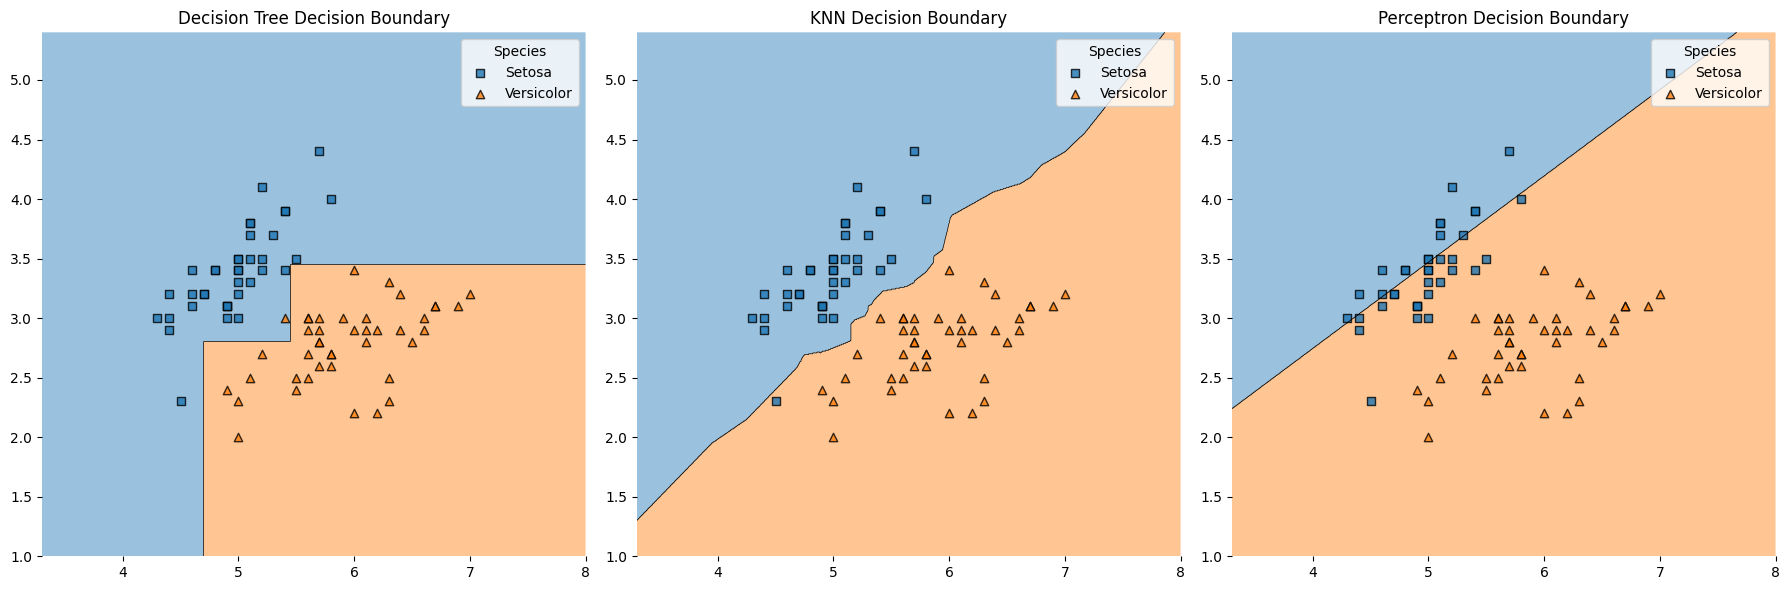

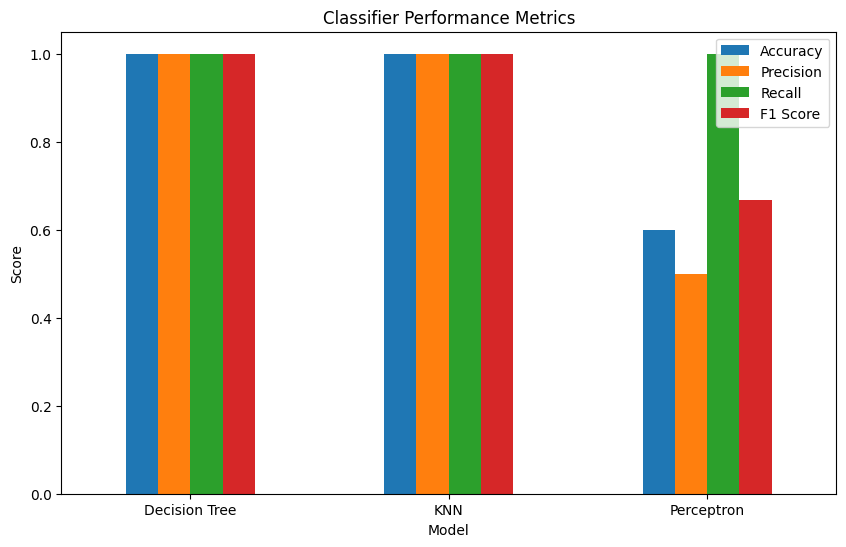

In [3]:
# Problem #4: Comparing Decision Tree, KNN, and Perceptron

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions

# Load the Iris dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
column_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
iris_data = pd.read_csv(url, header=None, names=column_names)

# Convert species names to numerical labels
iris_data['Species'] = iris_data['Species'].astype('category').cat.codes

# We use only the first 100 samples for binary classification (setosa and versicolor)
iris_data = iris_data[:100]

# Create a mapping from numerical labels to species names
label_dict = {0: 'Setosa', 1: 'Versicolor'}

# Split the dataset into features and target variable
X = iris_data[['SepalLengthCm', 'SepalWidthCm']].values  # Use only two features for visualization
y = iris_data['Species'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features for Perceptron and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementing Decision Tree from scratch
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((num / m) ** 2 for num in num_parent)
        best_idx, best_thr = None, None

        for idx in range(n):
            valid_indices = ~np.isnan(X[:, idx])
            X_valid = X[valid_indices, idx]
            y_valid = y[valid_indices]

            if len(X_valid) <= 1:
                continue

            thresholds, classes = zip(*sorted(zip(X_valid, y_valid)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, len(X_valid)):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes_))
                gini_right = 1.0 - sum((num_right[x] / (len(X_valid) - i)) ** 2 for x in range(self.n_classes_))
                gini = (i * gini_left + (len(X_valid) - i) * gini_right) / len(X_valid)
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

# Implementing KNN from scratch
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            predictions[i] = self._predict(x)
        return predictions

    def _predict(self, x):
        distances = self._distance(x, self.X_train)
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

    def _distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2, axis=1))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2), axis=1)
        else:
            raise ValueError(f"Unknown distance metric: {self.distance_metric}")

# Implementing Perceptron from scratch (now using scaled data)
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iter=50):
        self.learning_rate = learning_rate
        self.n_iter = n_iter

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1] + 1)
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.learning_rate * (target - self.predict(xi))
                self.weights[1:] += update * xi
                self.weights[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.weights[1:]) + self.weights[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

# Train and evaluate each model
models = {
    "Decision Tree": DecisionTree(max_depth=3),
    "KNN": KNN(k=3),
    "Perceptron": Perceptron(learning_rate=0.01, n_iter=10)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

    print(f'{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Visualize decision boundaries
plt.figure(figsize=(18, 6))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 3, i + 1)
    plot_decision_regions(X_train, y_train, clf=model, legend=2)
    plt.title(f'{name} Decision Boundary')
    # Update legend labels with species names
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [label_dict[int(label)] for label in labels]
    plt.legend(handles, labels, title='Species')

plt.tight_layout()
plt.show()

# Plot performance metrics
metrics_df = pd.DataFrame(results)
metrics_df.set_index("Model", inplace=True)
metrics_df.plot(kind="bar", figsize=(10, 6))
plt.title("Classifier Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


Silhouette Score: 0.51


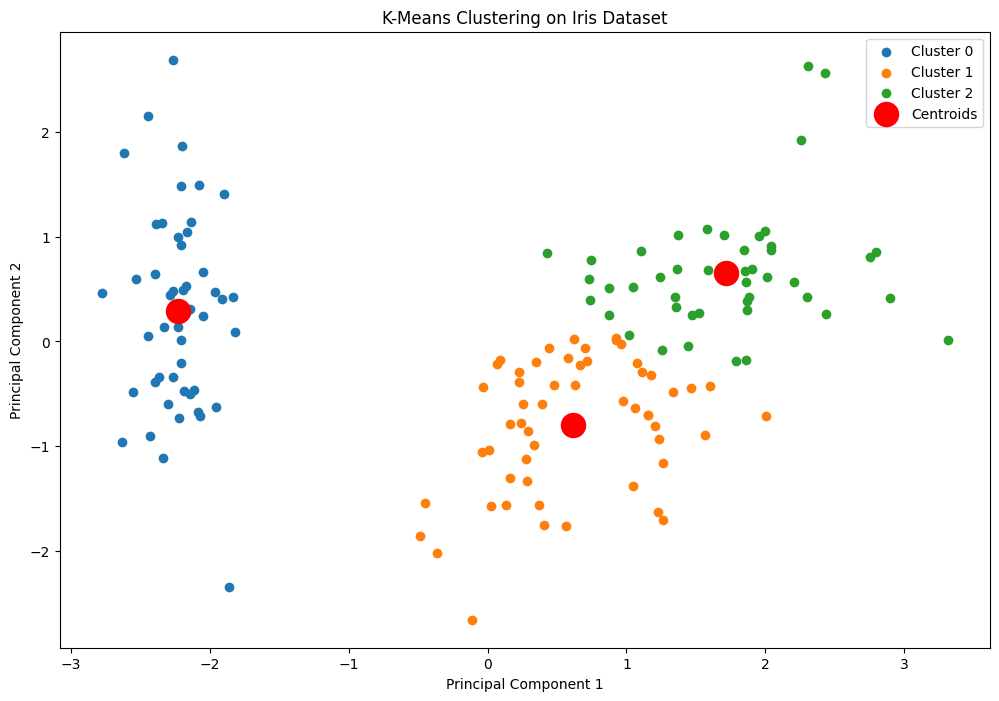

In [5]:
# Problem #5: K-Means Clustering and Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means Clustering Implementation
class KMeans:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_iter):
            self.labels = self._assign_labels(X)
            new_centroids = self._compute_centroids(X)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids

    def predict(self, X):
        return self._assign_labels(X)

    def _assign_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X):
        return np.array([X[self.labels == i].mean(axis=0) for i in range(self.n_clusters)])

# Train and evaluate K-Means
n_clusters = 3
model = KMeans(n_clusters=n_clusters)
model.fit(X_pca)
y_pred = model.predict(X_pca)

# Compute silhouette score
sil_score = silhouette_score(X_pca, y_pred)
print(f"Silhouette Score: {sil_score:.2f}")

# Plot the clusters
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.scatter(X_pca[y_pred == i, 0], X_pca[y_pred == i, 1], label=f'Cluster {i}')
plt.scatter(model.centroids[:, 0], model.centroids[:, 1], s=300, c='red', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('K-Means Clustering on Iris Dataset')
plt.show()


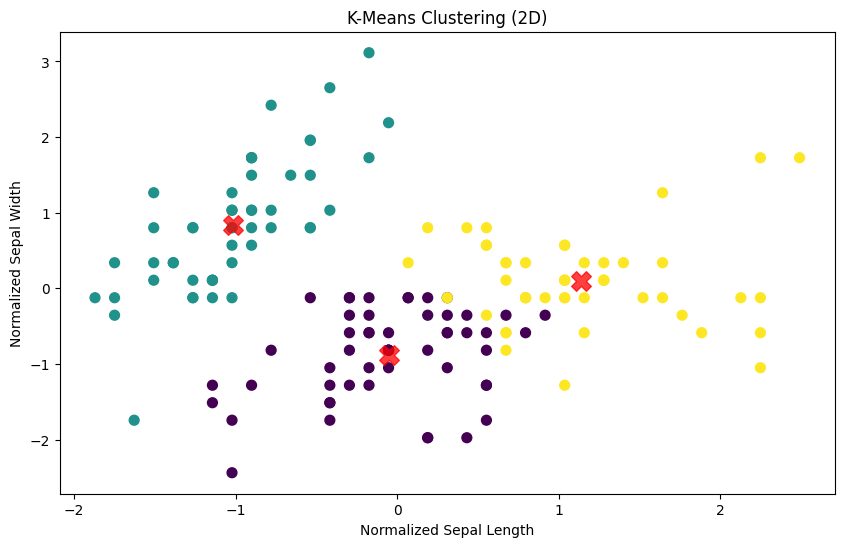

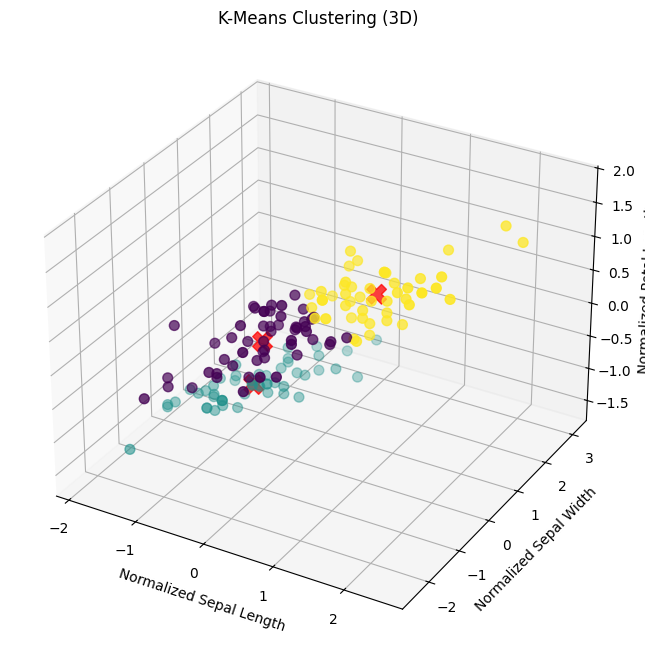

        Actual  Cluster
0  Iris-setosa        1
1  Iris-setosa        1
2  Iris-setosa        1
3  Iris-setosa        1
4  Iris-setosa        1
5  Iris-setosa        1
6  Iris-setosa        1
7  Iris-setosa        1
8  Iris-setosa        1
9  Iris-setosa        1
Silhouette Score: 0.46


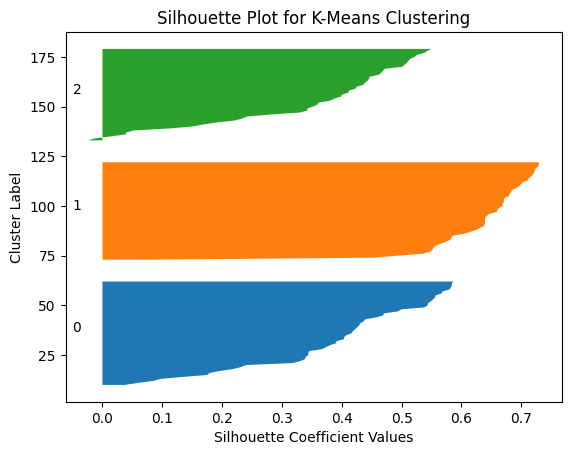

In [7]:
#Problem #5: K-Means Clustering and Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Load the Iris dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
column_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
iris_data = pd.read_csv(url, header=None, names=column_names)

# Normalize the dataset
scaler = StandardScaler()
X_normalized = scaler.fit_transform(iris_data.iloc[:, :-1])

# Apply k-means clustering with k=3 and explicitly set n_init
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_assignments = kmeans.fit_predict(X_normalized)
centroids = kmeans.cluster_centers_

# 2D Visualization of the cluster assignments
plt.figure(figsize=(10, 6))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=cluster_assignments, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means Clustering (2D)')
plt.xlabel('Normalized Sepal Length')
plt.ylabel('Normalized Sepal Width')
plt.show()

# 3D Visualization of the cluster assignments
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_normalized[:, 0], X_normalized[:, 1], X_normalized[:, 2], c=cluster_assignments, cmap='viridis', s=50)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=200, alpha=0.75, marker='X')
ax.set_title('K-Means Clustering (3D)')
ax.set_xlabel('Normalized Sepal Length')
ax.set_ylabel('Normalized Sepal Width')
ax.set_zlabel('Normalized Petal Length')
plt.show()

# Compare the cluster assignments with the actual class labels
comparison_df = pd.DataFrame({'Actual': iris_data['Species'], 'Cluster': cluster_assignments})
print(comparison_df.head(10))

# Calculate silhouette scores
silhouette_avg = silhouette_score(X_normalized, cluster_assignments)
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Plot silhouette scores
sample_silhouette_values = silhouette_samples(X_normalized, cluster_assignments)
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_assignments == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.title('Silhouette Plot for K-Means Clustering')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.show()


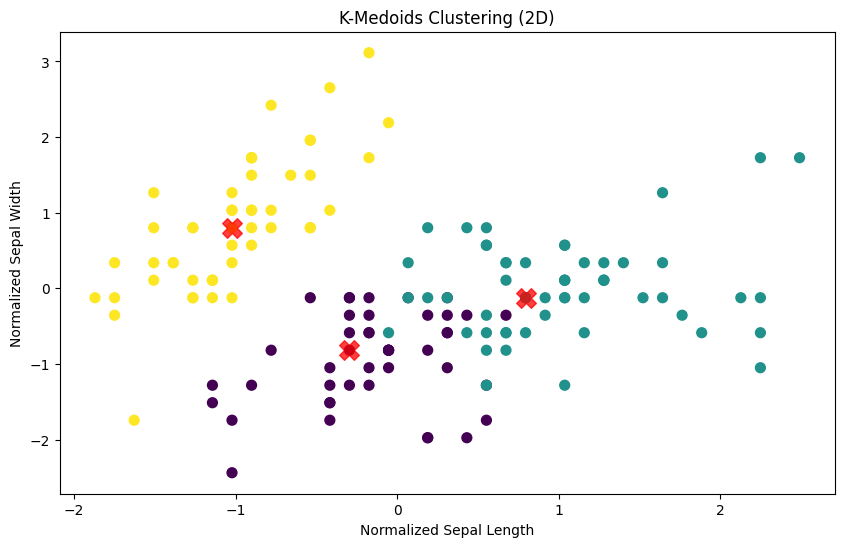

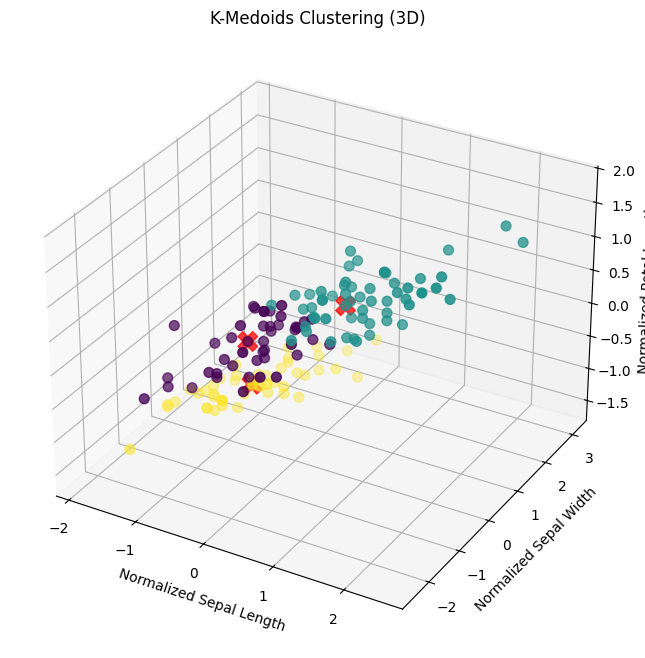

        Actual  K-Means Cluster  K-Medoids Cluster
0  Iris-setosa                1                  2
1  Iris-setosa                1                  2
2  Iris-setosa                1                  2
3  Iris-setosa                1                  2
4  Iris-setosa                1                  2
5  Iris-setosa                1                  2
6  Iris-setosa                1                  2
7  Iris-setosa                1                  2
8  Iris-setosa                1                  2
9  Iris-setosa                1                  2
Silhouette Score for K-Medoids: 0.45
Silhouette Score for K-Means: 0.46
Silhouette Score for K-Medoids: 0.45


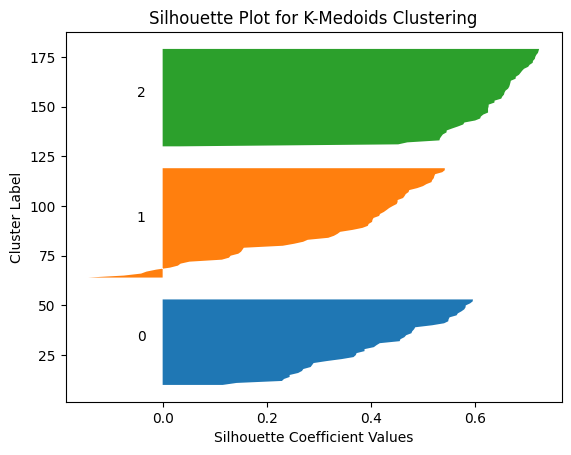

In [20]:
#Problem #6: K-Medoids Clustering and Comparison with K-Means

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Load the Iris dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
column_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
iris_data = pd.read_csv(url, header=None, names=column_names)

# Normalize the dataset
scaler = StandardScaler()
X_normalized = scaler.fit_transform(iris_data.iloc[:, :-1])

# Implementing K-Medoids clustering manually using PAM (Partitioning Around Medoids)

def k_medoids(X, n_clusters, max_iter=300):
    m, n = X.shape
    D = pairwise_distances(X, metric='euclidean')
    medoids = np.random.choice(m, n_clusters, replace=False)
    labels = np.argmin(D[:, medoids], axis=1)
    for _ in range(max_iter):
        new_medoids = np.array([np.argmin(np.sum(D[:, labels == i], axis=1)) for i in range(n_clusters)])
        new_labels = np.argmin(D[:, new_medoids], axis=1)
        if np.all(medoids == new_medoids):
            break
        medoids = new_medoids
        labels = new_labels
    return medoids, labels

# Apply k-medoids clustering with k=3
medoids, kmedoids_assignments = k_medoids(X_normalized, n_clusters=3)

# 2D Visualization of the k-medoids cluster assignments
plt.figure(figsize=(10, 6))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=kmedoids_assignments, cmap='viridis', s=50)
plt.scatter(X_normalized[medoids, 0], X_normalized[medoids, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Medoids Clustering (2D)')
plt.xlabel('Normalized Sepal Length')
plt.ylabel('Normalized Sepal Width')
plt.show()

# 3D Visualization of the k-medoids cluster assignments
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_normalized[:, 0], X_normalized[:, 1], X_normalized[:, 2], c=kmedoids_assignments, cmap='viridis', s=50)
ax.scatter(X_normalized[medoids, 0], X_normalized[medoids, 1], X_normalized[medoids, 2], c='red', s=200, alpha=0.75, marker='X')
ax.set_title('K-Medoids Clustering (3D)')
ax.set_xlabel('Normalized Sepal Length')
ax.set_ylabel('Normalized Sepal Width')
ax.set_zlabel('Normalized Petal Length')
plt.show()

# Compare the cluster assignments with the actual class labels
comparison_df = pd.DataFrame({'Actual': iris_data['Species'], 'K-Means Cluster': cluster_assignments, 'K-Medoids Cluster': kmedoids_assignments})
print(comparison_df.head(10))

# Calculate silhouette scores for k-medoids
silhouette_avg_kmedoids = silhouette_score(X_normalized, kmedoids_assignments)
print(f'Silhouette Score for K-Medoids: {silhouette_avg_kmedoids:.2f}')

# Compare silhouette scores
print(f'Silhouette Score for K-Means: {silhouette_avg:.2f}')
print(f'Silhouette Score for K-Medoids: {silhouette_avg_kmedoids:.2f}')

# Plot silhouette scores for k-medoids
sample_silhouette_values_kmedoids = silhouette_samples(X_normalized, kmedoids_assignments)
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values_kmedoids[kmedoids_assignments == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.title('Silhouette Plot for K-Medoids Clustering')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.show()
